# Analisi AI vs Human

#### Il sistema è progettato per eliminare ogni indizio semantico o lessicale e concentrarsi esclusivamente<br>sulla firma stilometrica del processo generativo. Non riconosciamo cosa dice un testo, ma come viene prodotto.<br> Questo ci permette di scoprire testi generati artificialmente anche quando sono mascherati o semanticamente neutri


In [1]:
import sys; print(sys.executable)

c:\Users\compu\AppData\Local\Programs\Python\Python311\python.exe


In [120]:
pip install tabulate emoji textstat

Note: you may need to restart the kernel to use updated packages.


In [121]:
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---- ----------------------------------- 1.3/12.8 MB 6.7 MB/s eta 0:00:02
     -------- ------------------------------- 2.6/12.8 MB 7.2 MB/s eta 0:00:02
     ------------- -------------------------- 4.2/12.8 MB 7.0 MB/s eta 0:00:02
     ------------------ --------------------- 5.8/12.8 MB 7.2 MB/s eta 0:00:01
     ---------------------- ----------------- 7.1/12.8 MB 7.1 MB/s eta 0:00:01
     --------------------------- ------------ 8.7/12.8 MB 7.2 MB/s eta 0:00:01
     ------------------------------- -------- 10.0/12.8 MB 7.2 MB/s eta 0:00:01
     ------------------------------------ --- 11.5/12.8 MB 7.2 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 7.0 MB/s  0:00:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## import delle librerie

In [122]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.


In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spacy
from textstat import flesch_reading_ease, flesch_kincaid_grade
import seaborn as sns
from scipy.stats import entropy
from collections import Counter
import emoji

## caricamento del dataset 

In [124]:
# caricare il dataset 
df = pd.read_csv("ai_vs_human_dataset_medium.csv")
print("1. pulizia del dataset")
print(f"dataset caricato: {df.shape[0]} righe, {df.shape[1]} colonne")


1. pulizia del dataset
dataset caricato: 500 righe, 12 colonne


In [125]:
# panoramica dei dati 
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                500 non-null    int64  
 1   label             500 non-null    object 
 2   topic             500 non-null    object 
 3   text              500 non-null    object 
 4   length_chars      500 non-null    int64  
 5   length_words      500 non-null    int64  
 6   quality_score     500 non-null    float64
 7   sentiment         500 non-null    float64
 8   source_detail     500 non-null    object 
 9   timestamp         500 non-null    object 
 10  plagiarism_score  500 non-null    float64
 11  notes             157 non-null    object 
dtypes: float64(3), int64(3), object(6)
memory usage: 47.0+ KB


,id,length_chars,length_words,quality_score,sentiment,plagiarism_score
count,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000
mean,250.500000,115.152000,16.79800,3.502340,0.161240,0.124510
std,144.481833,39.208973,5.83449,0.900641,0.416834,0.095412
min,1.000000,65.000000,9.00000,1.500000,-0.590000,0.000000
25%,125.750000,87.000000,13.00000,2.847500,-0.170000,0.050000
50%,250.500000,103.000000,14.00000,3.540000,0.190000,0.104500
75%,375.250000,133.250000,20.00000,4.240000,0.490000,0.171500
max,500.000000,280.000000,41.00000,5.000000,0.900000,0.349000


## Cleaning

In [126]:
print(" 2. Pulizia del dataset mirata")

 2. Pulizia del dataset mirata


#### clean_text_for_nlp -> serve a pulire e normalizzare il testo prima di qualsiasi analisi NLP. <br> Obiettivo principale: rimuovere elementi che non portano informazione stilistica o semantica <br> ma potrebbero introdurre rumore o bias nel modello. In particolare: <br> 1. Rimuove il carattere "|" usato come marker interno o separatore nei dati. <br> 2. Elimina frasi boilerplate tipiche generate da AI (es. "Analysis indicates that…"), <br> che potrebbero creare un data leakage se il modello le imparasse come scorciatoia. <br> 3. Normalizza spazi, newline e tabulazioni, riducendo il testo a un formato uniforme, <br>pronto per tokenizzazione, feature extraction e modeling.

In [127]:
def clean_text_for_nlp(text):
    # 1. Rimozione marker di fonte interna e rumore tipico dell'AI
    text = re.sub(r'\|', '', text)
    
    # 2. Rimozione boilerplate (frasi standard che l'AI usa per iniziare)
    # Questi sono pattern comuni che confondono i modelli di tokenizzazione
    boilerplate_patterns = [
        r'\banalysis indicates that\b',  
        r'\bthe following summary on\b',
        r'\bthis article discusses\b',
        r'\bas someone who follows\b',
        r'\bi recently experienced\b',
        r'\bin my experience,?\b',
        r'\bbased on the data,?\b',
        r'\bcommunity feedback\b',
        r'\bresearch suggests\b',
        r'\baccording to the data\b'
    ]
    
    for pattern in boilerplate_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    
    # 3. Normalizzazione: rimuove newline, tabulazioni e doppi spazi
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text



df['text_cleaned'] = df['text'].apply(clean_text_for_nlp)
print(" - Colonna 'text' pulita in 'text_cleaned' (rimozione marker e boilerplate AI).")


 - Colonna 'text' pulita in 'text_cleaned' (rimozione marker e boilerplate AI).


In [128]:
def verify_cleaning_effectiveness(df, text_col='text_cleaned'):

    """
    Verifica che i pattern boilerplate siano stati effettivamente rimossi

    """
    print("\n" + "="*70)
    print("VERIFICA RIMOZIONE BOILERPLATE")
    print("="*70)
    critical_patterns = [
        'analysis indicates',
        'community feedback',
        'research suggests',
        'according to the data',
        'following summary',
        'article discusses'

    ]
    leakage_found = False
    for pattern in critical_patterns:
        count = df[text_col].str.lower().str.contains(pattern, regex=False).sum()
        status = ' LEAKAGE!' if count > 0 else '✅ OK'
        print(f"  '{pattern}': {count:4d} occorrenze {status}")

        if count > 0:
            leakage_found = True

    if leakage_found:
        print("\n ATTENZIONE: Rilevato potenziale data leakage!")
        print("    Verifica la funzione di pulizia.")
    else:

        print("\n Tutti i pattern boilerplate rimossi correttamente.")
    return not leakage_found

#### remove_special_chars -> pulisce il testo rimuovendo simboli e caratteri indesiderati. <br> In particolare: <br> 1. Rimuove tutte le emoji presenti nel testo usando il modulo `emoji`. <br> 2. Elimina qualsiasi carattere che non sia una lettera (a-z, A-Z), numero (0-9),  <br> spazio o punteggiatura base (.,!?) tramite espressione regolare.<br> 3. Restituisce il testo "pulito", pronto per analisi NLP, tokenizzazione o feature extraction.

In [129]:
import emoji

def remove_special_chars(text):
    # Rimuove emoji
    text = emoji.replace_emoji(text, replace='')
    # Rimuove caratteri non alfabetici e numerici comuni
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    return text

df['text_cleaned'] = df['text_cleaned'].apply(remove_special_chars)


#### Questa sezione normalizza ulteriormente il testo e crea versioni standardizzate <br>  per l'analisi NLP. In particolare: <br> 1. `text_cleaned`: <br> - Mantiene le maiuscole originali. <br> - Rimuove spazi iniziali e finali con `.str.strip()`. <br> 2. `text_cleaned_lower`: <br> - Converte tutto il testo in minuscolo usando `.str.lower()`. <br> - Utile per NLP quando si vogliono confrontare parole senza distinzione tra maiuscole/minuscole. <br> 3. Rimozione spazi multipli e newline: <br> - `re.sub(r'\s+', '', x)` elimina spazi multipli e newline all'interno del testo. <br> 4. Riduzione punteggiatura ripetuta: <br> - `re.sub(r'([.,!?])\1+', r'\1', x)` sostituisce sequenze di punteggiatura ripetuta  <br> (es. "!!!" o "..") con un singolo carattere. <br> Obiettivo generale: avere un testo **uniforme, pulito e coerente** pronto per <br> tokenizzazione, feature extraction o modeling.



In [130]:
# lowercasing 
df['text_cleaned'] = df['text_cleaned'].str.strip()  
df['text_cleaned_lower'] = df['text_cleaned'].str.lower()

print(" - Creata 'text_cleaned' (preserva maiuscole)")
print(" - Creata 'text_cleaned_lower' (lowercase)")

# Rimozione di spazi multipli e punteggiatura eccessiva
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: re.sub(r'\s+', ' ', x))
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: re.sub(r'([.,!?])\1+', r'\1', x))

 - Creata 'text_cleaned' (preserva maiuscole)
 - Creata 'text_cleaned_lower' (lowercase)


## Pulizia mirata per pattern AI "sospetti"

#### Geature Engineering: Rilevamento pattern tipici di testo generato da AI <br> 1. `ai_patterns_detect`: <br> - Lista di frasi e pattern linguistici <br> tipici che compaiono frequentemente nei testi AI. <br>  - Esempi: "analysis indicates", "research suggests", "the following summary", ecc. <br> 2. Funzione `count_ai_patterns(text)`: <br> - Converte il testo in minuscolo (`text.lower()`) per confronti case-insensitive. <br> - Conta quante volte ciascun pattern della lista appare nel testo. <br> - Restituisce un numero intero: il totale dei pattern trovati. <br> 3. Applicazione al DataFrame: <br> - Crea la colonna `ai_pattern_count` che contiene, per ogni testo, il numero di pattern tipici AI. <br> - Questa feature può essere utile per analisi esplorativa o come segnale di AI, <br> ma va usata con cautela nel modello finale per evitare **data leakage**. <br> 4. Output informativo: <br> - Stampa la media dei pattern AI nei testi etichettati come AI.



## sentinel feature per verificare che il modello non stia barando

In [131]:
# Feature Engineering: AI 
ai_patterns_detect = [
    'community response', 'research suggests', 'according to the data',
    'analysis indicates', 'this article discusses', 'the following summary'
]

def count_ai_patterns(text):
    text_lower = text.lower()
    return sum([1 for pattern in ai_patterns_detect if pattern in text_lower])

df['ai_pattern_count'] = df['text'].apply(count_ai_patterns)
print(f" - Feature 'ai_pattern_count' creata (AI avg: {df[df['label']=='ai']['ai_pattern_count'].mean():.2f})")


 - Feature 'ai_pattern_count' creata (AI avg: 0.82)


In [ ]:
# Lemmatizzazione
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])


# MODIFICA SUGGERITA
def lemmatize_texts_stylometric(texts, batch_size=500):
    docs = nlp.pipe(texts, batch_size=batch_size, n_process=-1)
    # Rimuoviamo il controllo 'if not token.is_stop'
    # Manteniamo le stop words perché la loro frequenza è una "firma"
    return [" ".join(token.lemma_ for token in doc) for doc in docs]

df['text_cleaned_lem'] = lemmatize_texts(df['text_cleaned'])

In [ ]:
def extract_deep_stylometric_features(text):
    # 0. Analisi preliminare (Usiamo il testo originale per la punteggiatura)
    doc = nlp(text) # Rimosso .lower() qui per non perdere info sulle maiuscole subito
    
    # Liste di supporto
    words = [token.text.lower() for token in doc if token.is_alpha]
    sentences = [sent.text.strip() for sent in doc.sents if len(sent.text.strip()) > 0]
    pos_tags = [token.pos_ for token in doc]
    
    features = {}

    # ========================================================================
    # 1. RITMO E VARIANZA (Punteggiatura e Respirazione)
    # ========================================================================
    # Varianza intervalli punteggiatura (Novità!)
    # Gli umani hanno pause irregolari, l'AI è costante.
    punc_indices = [i for i, token in enumerate(doc) if token.is_punct]
    if len(punc_indices) > 2:
        intervals = np.diff(punc_indices)
        features['punc_interval_variance'] = np.var(intervals)
    else:
        features['punc_interval_variance'] = 0.0

    if len(sentences) > 1:
        sent_lengths = [len(sent.split()) for sent in sentences]
        features['sentence_length_cv'] = np.std(sent_lengths) / (np.mean(sent_lengths) + 1e-6)
    else:
        features['sentence_length_cv'] = 0.0

    # ========================================================================
    # 2. SINTASSI PURA (POS N-Grams Diversity)
    # ========================================================================
    # Diversità dei bigrammi POS (Novità!)
    # Misura quanto è varia la "melodia" grammaticale
    if len(pos_tags) > 1:
        pos_bigrams = [f"{pos_tags[i]}_{pos_tags[i+1]}" for i in range(len(pos_tags)-1)]
        features['pos_ngram_diversity'] = len(set(pos_bigrams)) / (len(pos_bigrams) + 1e-6)
    else:
        features['pos_ngram_diversity'] = 0.0

    # Entropia POS (Esistente)
    pos_counts = Counter(pos_tags)
    pos_probs = np.array([count / len(pos_tags) for count in pos_counts.values()])
    features['pos_entropy'] = entropy(pos_probs)

    # ========================================================================
    # 3. COMPLESSITÀ ALBERO SINTATTICO
    # ========================================================================
    tree_depths = []
    for sent in doc.sents:
        max_depth = 0
        for token in sent:
            depth = 1
            curr = token
            while curr.head != curr:
                depth += 1
                curr = curr.head
            max_depth = max(max_depth, depth)
        tree_depths.append(max_depth)
    
    features['avg_tree_depth'] = np.mean(tree_depths) if tree_depths else 0.0
    features['tree_depth_std'] = np.std(tree_depths) if len(tree_depths) > 1 else 0.0

    # ========================================================================
    # 4. RIPETIZIONE (Windowed TTR)
    # ========================================================================
    window_size = 50
    ttr_values = []
    for i in range(0, len(words) - window_size, window_size):
        window = words[i:i+window_size]
        ttr_values.append(len(set(window)) / len(window))
    features['ttr_variance'] = np.var(ttr_values) if len(ttr_values) > 1 else 0.0

    # ========================================================================
    # 5. FUNCTION WORDS & FORMALITY
    # ========================================================================
    function_words = {'the', 'a', 'an', 'of', 'to', 'in', 'for', 'on', 'at', 'by', 'with', 'from'}
    features['function_word_ratio'] = sum(1 for w in words if w in function_words) / (len(words) + 1e-6)
    
    nominalizations = ['tion', 'ment', 'ness', 'ity', 'ance', 'ence']
    features['nominalization_rate'] = sum(1 for w in words if any(w.endswith(s) for s in nominalizations)) / (len(words) + 1e-6)

    # ========================================================================
    # 6. MARKERS UMANI (Contrazioni ed Ellissi)
    # ========================================================================
    # Le contrazioni sono forti indicatori umani
    contractions = ["n't", "'m", "'re", "'ve", "'ll", "'d", "'s"]
    features['contraction_rate'] = sum(text.lower().count(c) for c in contractions) / (len(words) + 1e-6)
    features['ellipsis_count'] = text.count('...')

    return pd.Series(features)

In [134]:
print("\n" + "="*70)
print("3. RIMOZIONE LEAKAGE SEMANTICO (KEYWORD)")
print("="*70)

def remove_semantic_leakage(text):
    """
    Rimuove SOLO keyword che rivelano direttamente la classe:
    - AI, GPT, ChatGPT, LLM, Claude, Gemini, etc.
    - 'human', 'person', 'writer', 'author' (quando usati come label)
    
    MA PRESERVA:
    - Named entities (nomi propri specifici)
    - Parole comuni che contengono 'ai' (main,ait, etc.)
    """
    
    leakage_keywords = [
        # AI Models
        r'\bgpt[-\s]?\d*\b', r'\bchatgpt\b', r'\bllm\b', r'\bllama\b',
        r'\bclaude\b', r'\bgemini\b', r'\bmistral\b', r'\bai\smodel\b',
        r'\blanguage\smodel\b', r'\bartificial\sintelligence\b',
        
        # Meta-linguistic (AI parla di sé)
        r'\bgenerated\sby\b', r'\btrained\son\b', r'\bneural\snetwork\b',
        
        # Label leakage (solo se standalone)
        r'\bhuman\swriter\b', r'\bhuman\sauthor\b', r'\bwritten\sby\sai\b'
    ]
    
    for pattern in leakage_keywords:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    
    # Rimuovi 'ai' solo se standalone (non in 'main', 'wait', etc.)
    text = re.sub(r'\bai\b', '', text, flags=re.IGNORECASE)
    
    # Pulizia finale
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


df['text_cleaned'] = df['text_cleaned'].apply(remove_semantic_leakage)
print("✅ Keyword di leakage rimosse")


3. RIMOZIONE LEAKAGE SEMANTICO (KEYWORD)
✅ Keyword di leakage rimosse


In [177]:
# AGGIUNTA LOGICA
def punctuation_spacing_variance(text):
    # Calcola quanti token passano tra una virgola/punto e l'altro
    tokens = text.split()
    indices = [i for i, t in enumerate(tokens) if any(p in t for p in '.,;')]
    if len(indices) < 2: return 0
    intervals = np.diff(indices)
    return np.var(intervals) # Alta varianza = Umano, Bassa = AI

## Gestione dei valori mancanti mirata

In [135]:
print("3. Gestione dei valori mancanti")

3. Gestione dei valori mancanti


In [136]:
comment = """
Gestione della colonna 'notes' (variabile categorica)

1. Imputazione dei valori mancanti o vuoti:
   - Sostituisce le celle vuote (`''`) e i valori NaN con la stringa 'no_tone'.
   - Questo garantisce che tutti i record abbiano un valore valido nella colonna.

2. Conversione a tipo categorico:
   - Trasforma la colonna in tipo `category`, utile per:
     • Ridurre l’uso di memoria
     • Facilitare l’uso in modelli di machine learning che gestiscono feature categoriche

3. Output informativo:
   - Stampa un messaggio che conferma l’imputazione e la conversione a categoria.
"""


print(comment)



Gestione della colonna 'notes' (variabile categorica)

1. Imputazione dei valori mancanti o vuoti:
   - Sostituisce le celle vuote (`''`) e i valori NaN con la stringa 'no_tone'.
   - Questo garantisce che tutti i record abbiano un valore valido nella colonna.

2. Conversione a tipo categorico:
   - Trasforma la colonna in tipo `category`, utile per:
     • Ridurre l’uso di memoria
     • Facilitare l’uso in modelli di machine learning che gestiscono feature categoriche

3. Output informativo:
   - Stampa un messaggio che conferma l’imputazione e la conversione a categoria.



In [137]:
# 3.1 Colonna 'notes' (Categorica - Imputazione a 'no_tone')
df['notes'] = df['notes'].replace('', 'no_tone').fillna('no_tone')
df['notes'] = df['notes'].astype('category')
print(" - Imputazione Na/vuoti in 'notes' con 'no_tone' e conversione a categoria.")

 - Imputazione Na/vuoti in 'notes' con 'no_tone' e conversione a categoria.


In [138]:
comment = """
Imputazione dei valori mancanti per le colonne di tipo 'object'

Questa sezione gestisce in modo sistematico eventuali valori mancanti
nelle colonne categoriali (dtype 'object') del DataFrame.

In particolare:
1. Vengono selezionate tutte le colonne di tipo 'object'.
2. Per ciascuna colonna:
   - Si verifica la presenza di valori nulli (NaN).
   - Se presenti, si calcola la moda (valore più frequente) della colonna.
   - La moda viene usata per l’imputazione, garantendo coerenza statistica.
   - In caso estremo in cui la moda non esista, viene usato il valore di fallback 'Unknown'.
3. L’imputazione rende il dataset completo e pronto per le fasi successive
   di encoding e modeling.

Obiettivo: assicurare **robustezza e riproducibilità** del preprocessing,
anche in presenza di colonne apparentemente complete.
"""



print(comment)



Imputazione dei valori mancanti per le colonne di tipo 'object'

Questa sezione gestisce in modo sistematico eventuali valori mancanti
nelle colonne categoriali (dtype 'object') del DataFrame.

In particolare:
1. Vengono selezionate tutte le colonne di tipo 'object'.
2. Per ciascuna colonna:
   - Si verifica la presenza di valori nulli (NaN).
   - Se presenti, si calcola la moda (valore più frequente) della colonna.
   - La moda viene usata per l’imputazione, garantendo coerenza statistica.
   - In caso estremo in cui la moda non esista, viene usato il valore di fallback 'Unknown'.
3. L’imputazione rende il dataset completo e pronto per le fasi successive
   di encoding e modeling.

Obiettivo: assicurare **robustezza e riproducibilità** del preprocessing,
anche in presenza di colonne apparentemente complete.



In [139]:
# 3.2 Imputazione per altre colonne 
# Anche se le numeriche sono complete, mostriamo il processo per gli 'object'
for col in df.select_dtypes(include=['object']).columns:
     if df[col].isnull().any():
        mode_val = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
        df[col].fillna(mode_val, inplace=True)

## Gestione dei duplicati

In [140]:
print("4. Rimozione Duplicati")
df = df.drop_duplicates(keep = 'first')
print(f"righe finali dopo la rimozione dei duplicati: {df.shape[0]}")

4. Rimozione Duplicati
righe finali dopo la rimozione dei duplicati: 500


In [141]:
comment = """
Gestione degli outlier tramite clipping basato su IQR (Interquartile Range)

Questa sezione si occupa di ridurre l’impatto dei valori anomali (outlier)
nelle principali colonne numeriche utilizzate dal modello.

In particolare:
1. Vengono selezionate le colonne numeriche critiche per il modeling
   (es. lunghezza del testo, qualità, sentiment, plagio).
2. Per ogni colonna:
   - Si calcolano il primo (Q1) e il terzo quartile (Q3).
   - Si determina l’Interquartile Range (IQR = Q3 − Q1).
3. Si definiscono i limiti inferiori e superiori usando la regola:
   Q1 − 1.5 × IQR e Q3 + 1.5 × IQR.
4. I valori che eccedono questi limiti vengono **clippati**:
   - Non vengono eliminati dal dataset.
   - Vengono riportati entro un intervallo plausibile.

Obiettivo:
- Rendere le feature numeriche più stabili.
- Evitare che outlier estremi influenzino in modo eccessivo
  l’addestramento del modello.
- Preservare l’informazione senza perdita di campioni.
"""


print(comment)



Gestione degli outlier tramite clipping basato su IQR (Interquartile Range)

Questa sezione si occupa di ridurre l’impatto dei valori anomali (outlier)
nelle principali colonne numeriche utilizzate dal modello.

In particolare:
1. Vengono selezionate le colonne numeriche critiche per il modeling
   (es. lunghezza del testo, qualità, sentiment, plagio).
2. Per ogni colonna:
   - Si calcolano il primo (Q1) e il terzo quartile (Q3).
   - Si determina l’Interquartile Range (IQR = Q3 − Q1).
3. Si definiscono i limiti inferiori e superiori usando la regola:
   Q1 − 1.5 × IQR e Q3 + 1.5 × IQR.
4. I valori che eccedono questi limiti vengono **clippati**:
   - Non vengono eliminati dal dataset.
   - Vengono riportati entro un intervallo plausibile.

Obiettivo:
- Rendere le feature numeriche più stabili.
- Evitare che outlier estremi influenzino in modo eccessivo
  l’addestramento del modello.
- Preservare l’informazione senza perdita di campioni.



In [142]:
print("## 5. Gestione Outlier (Clipping IQR)")
# Definiamo le colonne numeriche critiche (quelle che useremo nel modello)
col_num_critical = ['length_words', 'quality_score', 'sentiment', 'plagiarism_score']

for col in col_num_critical:
    # Calcolo dei quantili e dell'IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR_val = Q3 - Q1
    
    # Limiti di clipping (1.5 * IQR)
    lower_bound = Q1 - 1.5 * IQR_val
    upper_bound = Q3 + 1.5 * IQR_val
    
    # Applichiamo il clipping: limitiamo i valori anomali senza eliminarli
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    print(f" - Colonna '{col}' clippata tra {lower_bound:.3f} e {upper_bound:.3f}")

## 5. Gestione Outlier (Clipping IQR)
 - Colonna 'length_words' clippata tra 2.500 e 30.500
 - Colonna 'quality_score' clippata tra 0.759 e 6.329
 - Colonna 'sentiment' clippata tra -1.160 e 1.480
 - Colonna 'plagiarism_score' clippata tra -0.132 e 0.354


## Feature Engineering e Standardizzazione Finale

In [143]:
comment = """
Feature Engineering e standardizzazione dei tipi: gestione del timestamp

Questa sezione si occupa della corretta gestione della variabile temporale,
fondamentale per analisi longitudinali o per individuare pattern nel tempo.

In particolare:
1. Verifica l’esistenza della colonna 'timestamp' nel DataFrame.
2. Converte la colonna in formato datetime usando `pd.to_datetime`:
   - `errors='coerce'` trasforma valori non validi in NaT, evitando errori di parsing.
3. Estrae feature temporali informative:
   - `creation_year`: anno di creazione
   - `creation_month`: mese di creazione
   - `creation_dayofweek`: giorno della settimana (0 = lunedì)
4. Rimuove la colonna originale 'timestamp' dopo l’estrazione delle informazioni.

Obiettivo:
- Trasformare una variabile temporale complessa in feature numeriche interpretabili.
- Rendere il dataset compatibile con modelli di machine learning.
- Consentire eventuali analisi su trend o stagionalità.
"""
print(comment)



Feature Engineering e standardizzazione dei tipi: gestione del timestamp

Questa sezione si occupa della corretta gestione della variabile temporale,
fondamentale per analisi longitudinali o per individuare pattern nel tempo.

In particolare:
1. Verifica l’esistenza della colonna 'timestamp' nel DataFrame.
2. Converte la colonna in formato datetime usando `pd.to_datetime`:
   - `errors='coerce'` trasforma valori non validi in NaT, evitando errori di parsing.
3. Estrae feature temporali informative:
   - `creation_year`: anno di creazione
   - `creation_month`: mese di creazione
   - `creation_dayofweek`: giorno della settimana (0 = lunedì)
4. Rimuove la colonna originale 'timestamp' dopo l’estrazione delle informazioni.

Obiettivo:
- Trasformare una variabile temporale complessa in feature numeriche interpretabili.
- Rendere il dataset compatibile con modelli di machine learning.
- Consentire eventuali analisi su trend o stagionalità.



In [144]:
print("6. Feature Engineering e Standardizzazione Tipi")

# 6.1 Gestione Timestamp (Cruciale per l'analisi temporale)
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    # Estraiamo le features temporali
    df['creation_year'] = df['timestamp'].dt.year
    df['creation_month'] = df['timestamp'].dt.month
    df['creation_dayofweek'] = df['timestamp'].dt.dayofweek
    df.drop('timestamp', axis=1, inplace=True)
    print(" - Colonna 'timestamp' convertita ed estratte feature temporali.")

6. Feature Engineering e Standardizzazione Tipi
 - Colonna 'timestamp' convertita ed estratte feature temporali.


In [145]:
comment = """
Standardizzazione delle variabili testuali e conversione a tipo 'category'

Questo blocco gestisce la pulizia e l’ottimizzazione delle colonne categoriali
' topic ' e ' source_detail ', rendendo i dati coerenti e più efficienti.

In particolare:
1. Verifica l’esistenza delle colonne nel DataFrame.
2. Converte esplicitamente i valori in stringa per evitare errori di tipo.
3. Applica operazioni di standardizzazione:
   - `strip()` rimuove spazi iniziali e finali
   - `title()` uniforma la capitalizzazione (es. "news article" → "News Article")
4. Converte le colonne nel tipo pandas `category`:
   - riduce l’uso di memoria
   - migliora l’efficienza di encoding e modeling
   - evita la proliferazione di categorie duplicate semanticamente identiche

Obiettivo:
- Garantire coerenza semantica nelle variabili categoriali.
- Prevenire rumore dovuto a formattazioni inconsistenti.
- Preparare il dataset a fasi successive di encoding e machine learning.
"""

print(comment)



Standardizzazione delle variabili testuali e conversione a tipo 'category'

Questo blocco gestisce la pulizia e l’ottimizzazione delle colonne categoriali
' topic ' e ' source_detail ', rendendo i dati coerenti e più efficienti.

In particolare:
1. Verifica l’esistenza delle colonne nel DataFrame.
2. Converte esplicitamente i valori in stringa per evitare errori di tipo.
3. Applica operazioni di standardizzazione:
   - `strip()` rimuove spazi iniziali e finali
   - `title()` uniforma la capitalizzazione (es. "news article" → "News Article")
4. Converte le colonne nel tipo pandas `category`:
   - riduce l’uso di memoria
   - migliora l’efficienza di encoding e modeling
   - evita la proliferazione di categorie duplicate semanticamente identiche

Obiettivo:
- Garantire coerenza semantica nelle variabili categoriali.
- Prevenire rumore dovuto a formattazioni inconsistenti.
- Preparare il dataset a fasi successive di encoding e machine learning.



In [146]:
# 6.2 Standardizzazione Stringhe e Conversione a Category
for col in ['topic', 'source_detail']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.title()
        df[col] = df[col].astype('category')
        print(f" - Colonna '{col}' standardizzata e convertita a 'category'.")

 - Colonna 'topic' standardizzata e convertita a 'category'.
 - Colonna 'source_detail' standardizzata e convertita a 'category'.


## codicfica delle variabili

In [147]:
# 6.3 Codifica della Variabile Target
df['label_encoded'] = df['label'].map({'human': 0, 'ai': 1}).astype('uint8')
print(" - Colonna 'label' codificata in 'label_encoded' (human=0, ai=1).")

 - Colonna 'label' codificata in 'label_encoded' (human=0, ai=1).


In [148]:
if df['label_encoded'].isna().any():
    print(f"{df['label_encoded'].isna().sum()} label non validi!")
    print(df[df['label_encoded'].isna()]['label'].unique())

In [149]:
comment = """
Feature Engineering Linguistiche per distinguere testi AI da testi Human

Questa sezione estrae caratteristiche testuali che possono evidenziare
differenze stilistiche e sintattiche tra contenuti generati da intelligenza artificiale
e contenuti scritti da esseri umani.

In particolare, per ciascun testo vengono calcolate:

1. avg_word_length: lunghezza media delle parole
   - AI tende a usare parole più lunghe o tecniche
2. lexical_diversity: diversità lessicale (numero di parole uniche / totale parole)
   - testi umani solitamente mostrano maggiore varietà
3. punctuation_density: densità di punteggiatura
   - Human tende a usare più !, ? e segni di interpunzione vari
4. exclamation_count / question_count: conteggio di ! e ? specifici
5. hedge_words_count: frequenza di parole “hedge” tipiche di AI
   (may, might, could, possibly, generally, typically, often)
6. intensifier_count: frequenza di parole intensificatrici
   (significantly, extremely, particularly, highly, notably)
7. first_person_count: conteggio dei pronomi in prima persona
   - Human tende a usare più I, my, me, mine, I'm, I've
8. sentence_count: numero di frasi identificate come segmenti separati da '.'

Obiettivo:
- Creare feature numeriche interpretabili per modellare la probabilità che un testo sia AI o Human.
- Migliorare explainability e capacità del modello di catturare differenze stilistiche.
- Fornire metriche linguistiche che possano essere correlate al target per analisi esplorativa.
"""

print(comment)



Feature Engineering Linguistiche per distinguere testi AI da testi Human

Questa sezione estrae caratteristiche testuali che possono evidenziare
differenze stilistiche e sintattiche tra contenuti generati da intelligenza artificiale
e contenuti scritti da esseri umani.

In particolare, per ciascun testo vengono calcolate:

1. avg_word_length: lunghezza media delle parole
   - AI tende a usare parole più lunghe o tecniche
2. lexical_diversity: diversità lessicale (numero di parole uniche / totale parole)
   - testi umani solitamente mostrano maggiore varietà
3. punctuation_density: densità di punteggiatura
   - Human tende a usare più !, ? e segni di interpunzione vari
4. exclamation_count / question_count: conteggio di ! e ? specifici
5. hedge_words_count: frequenza di parole “hedge” tipiche di AI
   (may, might, could, possibly, generally, typically, often)
6. intensifier_count: frequenza di parole intensificatrici
   (significantly, extremely, particularly, highly, notably)
7. first

In [150]:
## 7. Feature Engineering Linguistiche

print("7. Feature Engineering Linguistiche per Analisi e Explainability")

def extract_linguistic_features(text):
    words = text.split()
    sentences = text.split('.')
    
    # Lunghezza media parole (AI tende a parole più tecniche/lunghe)
    avg_word_len = np.mean([len(w) for w in words]) if words else 0
    
    # Diversità lessicale (Human più vario)
    lexical_diversity = len(set(words)) / len(words) if len(words) > 0 else 0
    
    # Punteggiatura (Human usa più !, ?)
    punctuation_density = sum([text.count(p) for p in '!?,;:']) / len(words) if words else 0
    exclamation_count = text.count('!')
    question_count = text.count('?')
    
    # Hedge words (AI usa più: may, might, could, possibly, generally)
    hedge_words = ['may', 'might', 'could', 'possibly', 'generally', 'typically', 'often']
    hedge_count = sum([text.lower().count(hw) for hw in hedge_words])
    
    # Intensifiers (AI usa: significantly, extremely, particularly)
    intensifiers = ['significantly', 'extremely', 'particularly', 'highly', 'notably']
    intensifier_count = sum([text.lower().count(intens) for intens in intensifiers])
    
    # First person pronouns (Human usa più: I, my, me)
    first_person = ['i ', 'my ', 'me ', 'mine ', "i'm ", "i've "]
    first_person_count = sum([text.lower().count(fp) for fp in first_person])
    
    return pd.Series({
        'avg_word_length': avg_word_len,
        'lexical_diversity': lexical_diversity,
        'punctuation_density': punctuation_density,
        'exclamation_count': exclamation_count,
        'question_count': question_count,
        'hedge_words_count': hedge_count,
        'intensifier_count': intensifier_count,
        'first_person_count': first_person_count,
        'sentence_count': len([s for s in sentences if s.strip()])
    })

# Applica le feature
linguistic_features = df['text_cleaned'].apply(extract_linguistic_features)
df = pd.concat([df, linguistic_features], axis=1)


print(f" - Aggiunte {len(linguistic_features.columns)} feature linguistiche.")
print(f" - Feature: {', '.join(linguistic_features.columns)}")


7. Feature Engineering Linguistiche per Analisi e Explainability
 - Aggiunte 9 feature linguistiche.
 - Feature: avg_word_length, lexical_diversity, punctuation_density, exclamation_count, question_count, hedge_words_count, intensifier_count, first_person_count, sentence_count


In [151]:

df['type_token_ratio'] = df['lexical_diversity']
df['avg_sentence_length'] = df['length_words'] / df['sentence_count'].replace(0, 1)


In [152]:
comment = """
Feature di Readability (Leggibilità) per testi AI vs Human

Questa sezione calcola metriche che quantificano quanto un testo sia 
facile o difficile da leggere, utile per distinguere testi generati 
da AI da testi scritti da esseri umani.

In particolare, per ciascun testo vengono calcolate:

1. readability_score: indice di leggibilità Flesch Reading Ease
   - Valori più alti indicano testi più facili da leggere.
   - AI tende a produrre testi uniformi con leggibilità mediamente costante.

2. grade_level: livello scolastico stimato secondo Flesch-Kincaid Grade
   - Indica il grado di istruzione necessario per comprendere il testo.
   - Consente di rilevare differenze stilistiche e complessità tra AI e Human.

Gestione degli errori:
- Se il calcolo fallisce, vengono assegnati valori di default (readability_score=50.0, grade_level=8.0)
  per evitare errori di pipeline.

Obiettivi:
- Fornire feature numeriche aggiuntive per modellare la probabilità
  che un testo sia AI o Human.
- Migliorare explainability e analisi comparativa tra le classi.
- Supportare eventuali visualizzazioni e statistiche descrittive.
"""

print(comment)
 


Feature di Readability (Leggibilità) per testi AI vs Human

Questa sezione calcola metriche che quantificano quanto un testo sia 
facile o difficile da leggere, utile per distinguere testi generati 
da AI da testi scritti da esseri umani.

In particolare, per ciascun testo vengono calcolate:

1. readability_score: indice di leggibilità Flesch Reading Ease
   - Valori più alti indicano testi più facili da leggere.
   - AI tende a produrre testi uniformi con leggibilità mediamente costante.

2. grade_level: livello scolastico stimato secondo Flesch-Kincaid Grade
   - Indica il grado di istruzione necessario per comprendere il testo.
   - Consente di rilevare differenze stilistiche e complessità tra AI e Human.

Gestione degli errori:
- Se il calcolo fallisce, vengono assegnati valori di default (readability_score=50.0, grade_level=8.0)
  per evitare errori di pipeline.

Obiettivi:
- Fornire feature numeriche aggiuntive per modellare la probabilità
  che un testo sia AI o Human.
- Miglio

In [153]:
## 7.1. Feature di Readability (Leggibilità)
print(" 7.1. Feature di Readability")

def extract_readability_features(text):
    """
    Calcola metriche di leggibilità. 
    L'AI tende a produrre testi con punteggi molto uniformi, 
    mentre gli umani hanno una varianza molto più alta.
    """
    # Pulizia minima per evitare errori di textstat su stringhe quasi vuote
    clean_text = str(text).strip()
    if len(clean_text.split()) < 5:
        return pd.Series({'readability_score': 50.0, 'grade_level': 8.0})

    try:
        # Flesch Reading Ease: più alto è, più è facile da leggere (0-100)
        flesch_score = flesch_reading_ease(clean_text)
        
        # Flesch-Kincaid Grade Level: indica l'anno di scolarizzazione necessario
        grade_level = flesch_kincaid_grade(clean_text)
        
        # Clipping dei valori per evitare outlier estremi dovuti a errori di parsing
        flesch_score = np.clip(flesch_score, 0, 100)
        grade_level = np.clip(grade_level, 0, 20)
        
    except Exception:
        # Fallback su valori medi del dataset in caso di errore
        flesch_score = 50.0
        grade_level = 8.0
    
    return pd.Series({
        'readability_score': flesch_score,
        'grade_level': grade_level
    })

# Applicazione delle feature
print(" - Calcolo indici di leggibilità in corso...")
readability_cols = df['text_cleaned'].apply(extract_readability_features)
df = pd.concat([df, readability_cols], axis=1)

print(f" - Feature create: {', '.join(readability_cols.columns)}")

# Analisi comparativa avanzata
print("\n" + "="*50)
print("ANALISI COMPARATIVA: LEGGIBILITÀ (AI vs HUMAN)")
print("="*50)

# Calcoliamo media e deviazione standard per vedere l'uniformità dell'AI
readability_analysis = df.groupby('label')[['readability_score', 'grade_level']].agg(['mean', 'std'])
print(readability_analysis.round(2))

print("\nNota: L'AI spesso presenta una 'std' (deviazione standard) più bassa,")
print("indicando uno stile di scrittura più monotono e costante.")
print("="*50)

 7.1. Feature di Readability
 - Calcolo indici di leggibilità in corso...
 - Feature create: readability_score, grade_level

ANALISI COMPARATIVA: LEGGIBILITÀ (AI vs HUMAN)
      readability_score        grade_level      
                   mean    std        mean   std
label                                           
ai                30.23  23.05       11.72  3.59
human             35.38  20.94       11.22  3.14

Nota: L'AI spesso presenta una 'std' (deviazione standard) più bassa,
indicando uno stile di scrittura più monotono e costante.


### Le metriche di leggibilità mostrano che i testi AI risultano mediamente <br> meno leggibili, con un Flesch score più basso e un grade level leggermente più alto. <br> Questo riflette uno stile più uniforme e formale, <br> mentre i testi umani presentano una maggiore variabilità sintattica e lessicale

In [154]:
comment = """
Feature Named Entity Density per testi AI vs Human

Questa sezione calcola metriche relative alle Named Entities (persone, organizzazioni, luoghi)
per distinguere testi scritti da esseri umani da testi generati da AI.

Motivazione:
- I testi umani tendono a contenere più riferimenti specifici a persone, organizzazioni e luoghi.
- I testi AI spesso generano frasi più generiche e uniformi, con minore densità di entità riconoscibili.

Feature calcolate per ciascun testo:

1. entity_density: densità complessiva di entità (numero entità / numero parole)
2. person_entity_count: numero di entità di tipo PERSON
3. org_entity_count: numero di entità di tipo ORG
4. location_entity_count: numero di entità di tipo GPE (Geo-Political Entity)
5. total_entities: numero totale di entità riconosciute

Dettagli implementativi:
- Il testo viene limitato a 5000 caratteri per motivi di performance.
- In caso di errore, tutte le feature vengono impostate a 0 per evitare interruzioni.
- Utilizza spaCy con modello 'en_core_web_sm' per il Named Entity Recognition (NER).

Obiettivi:
- Fornire feature numeriche interpretabili e rilevanti per ML.
- Supportare analisi comparativa AI vs Human.
- Migliorare explainability del modello, evidenziando pattern semantici distintivi.
"""

print(comment)


Feature Named Entity Density per testi AI vs Human

Questa sezione calcola metriche relative alle Named Entities (persone, organizzazioni, luoghi)
per distinguere testi scritti da esseri umani da testi generati da AI.

Motivazione:
- I testi umani tendono a contenere più riferimenti specifici a persone, organizzazioni e luoghi.
- I testi AI spesso generano frasi più generiche e uniformi, con minore densità di entità riconoscibili.

Feature calcolate per ciascun testo:

1. entity_density: densità complessiva di entità (numero entità / numero parole)
2. person_entity_count: numero di entità di tipo PERSON
3. org_entity_count: numero di entità di tipo ORG
4. location_entity_count: numero di entità di tipo GPE (Geo-Political Entity)
5. total_entities: numero totale di entità riconosciute

Dettagli implementativi:
- Il testo viene limitato a 5000 caratteri per motivi di performance.
- In caso di errore, tutte le feature vengono impostate a 0 per evitare interruzioni.
- Utilizza spaCy con m

In [155]:
## 7.2 Named Entity Density
print("## 7.2. Named Entity Density")


nlp_ner = spacy.load("en_core_web_sm")

def extract_entity_features(text, batch_size=500):
    """Human usa più nomi propri, luoghi, organizzazioni specifiche"""
    try:
        doc = nlp_ner(text[:5000])  
        entities = [ent for ent in doc.ents]
        words = text.split()
        
        # Densità totale
        entity_density = len(entities) / len(words) if len(words) > 0 else 0
        
        # Conta per tipo
        entity_types = {}
        for ent in entities:
            entity_types[ent.label_] = entity_types.get(ent.label_, 0) + 1
        
        person_count = entity_types.get('PERSON', 0)
        org_count = entity_types.get('ORG', 0)
        gpe_count = entity_types.get('GPE', 0)  # Geo-Political Entity
        
        return pd.Series({
            'entity_density': entity_density,
            'person_entity_count': person_count,
            'org_entity_count': org_count,
            'location_entity_count': gpe_count,
            'total_entities': len(entities)
        })
    except:
        return pd.Series({
            'entity_density': 0,
            'person_entity_count': 0,
            'org_entity_count': 0,
            'location_entity_count': 0,
            'total_entities': 0
        })

# Applica con progress tracking
print(" - Estrazione Named Entities in corso (può richiedere 1-2 minuti)...")
entity_features = df['text_cleaned'].apply(extract_entity_features)
df = pd.concat([df, entity_features], axis=1)

print(f" - Aggiunte {len(entity_features.columns)} feature di Named Entity.")
print(f" - Feature: {', '.join(entity_features.columns)}")

# Comparazione
print("\nComparazione AI vs Human - Named Entities:")
print(df.groupby('label')[['entity_density', 'person_entity_count']].mean())

## 7.2. Named Entity Density
 - Estrazione Named Entities in corso (può richiedere 1-2 minuti)...
 - Aggiunte 5 feature di Named Entity.
 - Feature: entity_density, person_entity_count, org_entity_count, location_entity_count, total_entities

Comparazione AI vs Human - Named Entities:
       entity_density  person_entity_count
label                                     
ai           0.013028             0.171315
human        0.000000             0.000000


In [156]:
comment = """
Feature Sintattiche Avanzate per testi AI vs Human

Questa sezione estrae feature legate alla struttura sintattica e alla
regolarità stilistica dei testi, per distinguere contenuti generati da AI
da testi scritti da esseri umani.

Feature calcolate per ciascun testo:

1. passive_voice_ratio: proporzione di verbi in forma passiva
   - Pattern approssimativo basato su parole chiave: 'is', 'was', 'been', 'be', 'are', 'were'
   - Testi AI tendono ad avere costruzioni passive più regolari.

2. unique_bigram_ratio: rapporto tra bigrammi unici e totali
   - Misura della creatività lessicale e varietà combinatoria
   - Human tende a generare combinazioni di parole più varie.

3. sentence_length_variability: deviazione standard della lunghezza delle frasi
   - Testi umani mostrano maggiore variabilità nella lunghezza delle frasi.
   - AI tende a produrre frasi più uniformi.

4. contraction_density: densità di contrazioni (I'm, don't, can't, etc.)
   - Human utilizza più frequentemente contrazioni rispetto all’AI.

Obiettivi:

- Fornire feature sintattiche interpretabili e rilevanti per ML.
- Migliorare explainability del modello distinguendo pattern stilistici regolari vs variabili.
- Supportare analisi comparativa AI vs Human.
"""

print(comment)


Feature Sintattiche Avanzate per testi AI vs Human

Questa sezione estrae feature legate alla struttura sintattica e alla
regolarità stilistica dei testi, per distinguere contenuti generati da AI
da testi scritti da esseri umani.

Feature calcolate per ciascun testo:

1. passive_voice_ratio: proporzione di verbi in forma passiva
   - Pattern approssimativo basato su parole chiave: 'is', 'was', 'been', 'be', 'are', 'were'
   - Testi AI tendono ad avere costruzioni passive più regolari.

2. unique_bigram_ratio: rapporto tra bigrammi unici e totali
   - Misura della creatività lessicale e varietà combinatoria
   - Human tende a generare combinazioni di parole più varie.

3. sentence_length_variability: deviazione standard della lunghezza delle frasi
   - Testi umani mostrano maggiore variabilità nella lunghezza delle frasi.
   - AI tende a produrre frasi più uniformi.

4. contraction_density: densità di contrazioni (I'm, don't, can't, etc.)
   - Human utilizza più frequentemente contrazi

In [157]:
def extract_transition_entropy(text):
    """AI ha transizioni POS più prevedibili"""
    doc = nlp(text)
    pos_bigrams = [(doc[i].pos_, doc[i+1].pos_) for i in range(len(doc)-1)]
    bigram_counts = Counter(pos_bigrams)
    probs = np.array(list(bigram_counts.values())) / len(pos_bigrams)
    return entropy(probs)

In [158]:
## 7.3 Feature Sintattiche Avanzate
print("7.3. Feature Sintattiche Avanzate")

def extract_syntactic_features(text):
    """Analisi sintattica - AI ha pattern più regolari"""
    
    # Passive voice detection (approssimato)
    # Pattern: "is/was/been/be + past participle"
    passive_indicators = ['is ', 'was ', 'been ', 'be ', 'are ', 'were ']
    passive_count = sum([text.lower().count(ind) for ind in passive_indicators])
    words = text.split()
    passive_ratio = passive_count / len(words) if len(words) > 0 else 0
    
    # Unique bigrams (creatività lessicale)
    bigrams = [f"{words[i]} {words[i+1]}" for i in range(len(words)-1)]
    unique_bigram_ratio = len(set(bigrams)) / len(bigrams) if len(bigrams) > 0 else 0
    
    # Sentence length variability (Human più vario)
    sentences = [s.strip() for s in text.split('.') if s.strip()]
    if len(sentences) > 1:
        sent_lengths = [len(s.split()) for s in sentences]
        sentence_length_std = np.std(sent_lengths)
    else:
        sentence_length_std = 0
    
    # Contraction usage (Human usa più: I'm, don't, can't)
    contractions = ["n't", "'m", "'re", "'ve", "'ll", "'d"]
    contraction_count = sum([text.count(contr) for contr in contractions])
    contraction_density = contraction_count / len(words) if len(words) > 0 else 0
    
    return pd.Series({
        'passive_voice_ratio': passive_ratio,
        'unique_bigram_ratio': unique_bigram_ratio,
        'sentence_length_variability': sentence_length_std,
        'contraction_density': contraction_density
    })

# Applica le feature
syntactic_features = df['text_cleaned'].apply(extract_syntactic_features)
df = pd.concat([df, syntactic_features], axis=1)

print(f" - Aggiunte {len(syntactic_features.columns)} feature sintattiche.")
print(f" - Feature: {', '.join(syntactic_features.columns)}")

# Comparazione
print("\nComparazione AI vs Human - Sintassi:")
print(df.groupby('label')[['passive_voice_ratio', 'contraction_density']].mean())

7.3. Feature Sintattiche Avanzate
 - Aggiunte 4 feature sintattiche.
 - Feature: passive_voice_ratio, unique_bigram_ratio, sentence_length_variability, contraction_density

Comparazione AI vs Human - Sintassi:
       passive_voice_ratio  contraction_density
label                                          
ai                0.061829                  0.0
human             0.055920                  0.0


In [159]:
comment = """
Riepilogo Feature Engineering

Scopo:
- Fornire una panoramica completa delle feature create durante il preprocessing
  e la feature engineering, raggruppandole per categorie concettuali.
- Identificare le feature più discriminanti rispetto al target (AI vs Human).

Passaggi principali:

1. Conta totale delle feature ingegnerizzate:
   - Si escludono le colonne originali del dataset, le colonne di testo intermedio
     ('text_cleaned', 'text_cleaned_lower', ecc.) e le feature temporali.

2. Raggruppamento per categoria:
   - Linguistiche Base: statistiche generali sul testo (lunghezza media parole,
     diversità lessicale, densità di punteggiatura, ecc.)
   - Firme Stilistiche AI: pattern tipici dei testi AI (hedge words, intensifiers,
     count di frasi boilerplate)
   - Firme Stilistiche Human: pattern tipici dei testi umani (pronomi in prima
     persona, contrazioni)
   - Readability: metriche di leggibilità (Flesch Reading Ease, grade level)
   - Named Entities: densità e conteggio di entità nominate (PERSON, ORG, GPE)
   - Sintattiche: feature sintattiche avanzate (passive voice, bigrammi unici, 
     variabilità lunghezza frasi)

3. Visualizzazione delle feature per categoria:
   - Stampa la lista di feature presenti in ciascuna categoria.

4. Analisi di correlazione con il target:
   - Calcola la correlazione tra ciascuna feature numerica e 'label_encoded'
     (0 = Human, 1 = AI).
   - Stampa le top 5 feature positive (fortemente associate a AI) e negative
     (fortemente associate a Human).

Obiettivi metodologici:
- Fornire un quadro chiaro della pipeline di feature engineering.
- Identificare le feature più rilevanti e interpretabili per modelli di ML.
- Facilitare analisi esplorative e spiegazioni del modello (explainability).
"""

print(comment)


Riepilogo Feature Engineering

Scopo:
- Fornire una panoramica completa delle feature create durante il preprocessing
  e la feature engineering, raggruppandole per categorie concettuali.
- Identificare le feature più discriminanti rispetto al target (AI vs Human).

Passaggi principali:

1. Conta totale delle feature ingegnerizzate:
   - Si escludono le colonne originali del dataset, le colonne di testo intermedio
     ('text_cleaned', 'text_cleaned_lower', ecc.) e le feature temporali.

2. Raggruppamento per categoria:
   - Linguistiche Base: statistiche generali sul testo (lunghezza media parole,
     diversità lessicale, densità di punteggiatura, ecc.)
   - Firme Stilistiche AI: pattern tipici dei testi AI (hedge words, intensifiers,
     count di frasi boilerplate)
   - Firme Stilistiche Human: pattern tipici dei testi umani (pronomi in prima
     persona, contrazioni)
   - Readability: metriche di leggibilità (Flesch Reading Ease, grade level)
   - Named Entities: densità e conte

In [160]:
## 7.4 Riepilogo Feature Engineering
print("\n" + "="*60)
print("## 7.4. RIEPILOGO FEATURE ENGINEERING")
print("="*60)

# Conta tutte le feature create
original_cols = ['text', 'label', 'topic', 'quality_score', 'sentiment', 
                 'plagiarism_score', 'length_words', 'notes', 'source_detail']

engineered_features = [col for col in df.columns if col not in original_cols 
                       and not col.startswith('text_') 
                       and col not in ['label_encoded', 'creation_year', 'creation_month', 'creation_dayofweek']]

print(f"\nTotale Feature Ingegnerizzate: {len(engineered_features)}")
print("\nLista completa:")

# Raggruppa per categoria
feature_categories = {
    'Linguistiche Base': ['avg_word_length', 'lexical_diversity', 'punctuation_density', 
                          'exclamation_count', 'question_count', 'sentence_count', 
                          'avg_sentence_length', 'type_token_ratio'],
    'Firme Stilistiche AI': ['hedge_words_count', 'intensifier_count', 'ai_pattern_count'],
    'Firme Stilistiche Human': ['first_person_count', 'contraction_density'],
    'Readability': ['readability_score', 'grade_level'],
    'Named Entities': ['entity_density', 'person_entity_count', 'org_entity_count', 
                       'location_entity_count', 'total_entities'],
    'Sintattiche': ['passive_voice_ratio', 'unique_bigram_ratio', 'sentence_length_variability']
}

for category, features in feature_categories.items():
    existing = [f for f in features if f in df.columns]
    if existing:
        print(f"\n  🔹 {category} ({len(existing)}):")
        for feat in existing:
            print(f"     - {feat}")

# Statistiche comparative
print("\n" + "="*60)
print("TOP 5 FEATURE PIÙ DISCRIMINANTI (Correlazione con Target)")
print("="*60)

if 'label_encoded' in df.columns:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlations = df[numeric_cols].corr()['label_encoded'].sort_values(ascending=False)
    
    print("\nPositive (più alta = più AI):")
    print(correlations[1:6].to_string())  
    
    print("\nNegative (più bassa = più Human):")
    print(correlations[-5:].to_string())

print("\n" + "="*60)


## 7.4. RIEPILOGO FEATURE ENGINEERING

Totale Feature Ingegnerizzate: 25

Lista completa:

  🔹 Linguistiche Base (8):
     - avg_word_length
     - lexical_diversity
     - punctuation_density
     - exclamation_count
     - question_count
     - sentence_count
     - avg_sentence_length
     - type_token_ratio

  🔹 Firme Stilistiche AI (3):
     - hedge_words_count
     - intensifier_count
     - ai_pattern_count

  🔹 Firme Stilistiche Human (2):
     - first_person_count
     - contraction_density

  🔹 Readability (2):
     - readability_score
     - grade_level

  🔹 Named Entities (5):
     - entity_density
     - person_entity_count
     - org_entity_count
     - location_entity_count
     - total_entities

  🔹 Sintattiche (3):
     - passive_voice_ratio
     - unique_bigram_ratio
     - sentence_length_variability

TOP 5 FEATURE PIÙ DISCRIMINANTI (Correlazione con Target)

Positive (più alta = più AI):
ai_pattern_count       0.564333
avg_word_length        0.347050
total_entities

## Output Finale del DataFrame Pulito

In [161]:
# Rimuoviamo le colonne originali non più necessarie
cols_to_drop_final = ['id', 'text', 'label'] 
df_clean = df.drop(columns=[c for c in cols_to_drop_final if c in df.columns])

print("\n--- RISULTATO FINALE: DATAFRAME PRONTO PER IL MODELING ---")
print(f"Dimensioni finali: {df_clean.shape[0]} righe, {df_clean.shape[1]} colonne.")
print("Tipi di dato finali:")
print(df_clean.dtypes.to_markdown())
print("-" * 50)
print("Anteprima del DataFrame Pulito e Processato:")
print(df_clean.head().to_markdown())


--- RISULTATO FINALE: DATAFRAME PRONTO PER IL MODELING ---
Dimensioni finali: 500 righe, 38 colonne.
Tipi di dato finali:
|                             | 0        |
|:----------------------------|:---------|
| topic                       | category |
| length_chars                | int64    |
| length_words                | float64  |
| quality_score               | float64  |
| sentiment                   | float64  |
| source_detail               | category |
| plagiarism_score            | float64  |
| notes                       | category |
| text_cleaned                | object   |
| text_cleaned_lower          | object   |
| ai_pattern_count            | int64    |
| text_cleaned_lem            | object   |
| creation_year               | int32    |
| creation_month              | int32    |
| creation_dayofweek          | int32    |
| label_encoded               | uint8    |
| avg_word_length             | float64  |
| lexical_diversity           | float64  |
| punctuation_den

In [162]:
print("8. Controllo Data Leakage")

# Verifica correlazione sospetta col target
corr_target = df_clean.corr(numeric_only=True)['label_encoded'].sort_values(ascending=False)

print("Correlazioni con il target (top 10):")
print(corr_target.head(10))


8. Controllo Data Leakage
Correlazioni con il target (top 10):
label_encoded          1.000000
ai_pattern_count       0.564333
avg_word_length        0.347050
person_entity_count    0.305520
total_entities         0.305520
entity_density         0.294534
quality_score          0.293877
grade_level            0.073302
passive_voice_ratio    0.057136
sentiment              0.041773
Name: label_encoded, dtype: float64


In [163]:
comment = """
8.1 Visualizzazioni Before/After Preprocessing

Scopo:
- Valutare l'impatto del preprocessing e della feature engineering sui testi
  e sulle feature numeriche.
- Visualizzare differenze tra testi originali e puliti, e tra classi AI vs Human.

Dettaglio dei grafici:

1. Text Length Distribution
   - Confronta la distribuzione della lunghezza dei testi (in caratteri)
     prima e dopo la pulizia ('text' vs 'text_cleaned').
   - Evidenzia quanto la rimozione di marker, emoji e boilerplate abbia ridotto
     rumore e uniformato i testi.

2. Word Count per Class
   - Boxplot della lunghezza dei testi (numero di parole) per classe
     dopo il clipping degli outlier.
   - Permette di osservare se AI e Human hanno distribuzioni simili o differenti.

3. Sentiment Distribution
   - Istogrammi dei punteggi di sentiment per AI e Human.
   - Aiuta a verificare differenze di tono emotivo tra le due classi.

4. Lexical Diversity
   - Confronto della diversità lessicale (ratio vocaboli unici/total words).
   - Human tendono a usare vocabolario più vario; AI tende a ripetere termini.

5. Hedge Words Count
   - Istogrammi del conteggio di parole hedge (may, might, could, etc.).
   - AI tende a usarle più frequentemente; visualizzazione conferma pattern.

6. First Person Count
   - Confronto dei pronomi in prima persona (I, my, me, etc.).
   - Human ne fanno un uso maggiore; utile come firma stilistica.

Tecniche e note:
- Uso di `plt.subplots` per creare una griglia 2x3 di grafici.
- Colori distinti e label per distinguere classi e stato prima/dopo pulizia.
- `tight_layout` per ottimizzare spaziatura.
- Salvataggio della figura ad alta risoluzione per documentazione/report.

Obiettivo generale:
- Fornire una visualizzazione chiara e immediata dell’effetto del preprocessing.
- Permettere di identificare pattern stilistici distintivi tra AI e Human.
"""
print(comment)


8.1 Visualizzazioni Before/After Preprocessing

Scopo:
- Valutare l'impatto del preprocessing e della feature engineering sui testi
  e sulle feature numeriche.
- Visualizzare differenze tra testi originali e puliti, e tra classi AI vs Human.

Dettaglio dei grafici:

1. Text Length Distribution
   - Confronta la distribuzione della lunghezza dei testi (in caratteri)
     prima e dopo la pulizia ('text' vs 'text_cleaned').
   - Evidenzia quanto la rimozione di marker, emoji e boilerplate abbia ridotto
     rumore e uniformato i testi.

2. Word Count per Class
   - Boxplot della lunghezza dei testi (numero di parole) per classe
     dopo il clipping degli outlier.
   - Permette di osservare se AI e Human hanno distribuzioni simili o differenti.

3. Sentiment Distribution
   - Istogrammi dei punteggi di sentiment per AI e Human.
   - Aiuta a verificare differenze di tono emotivo tra le due classi.

4. Lexical Diversity
   - Confronto della diversità lessicale (ratio vocaboli unici/total 

8.1. Visualizzazioni Impatto Preprocessing
 - Visualizzazione salvata in 'preprocessing_impact_visualization.png'


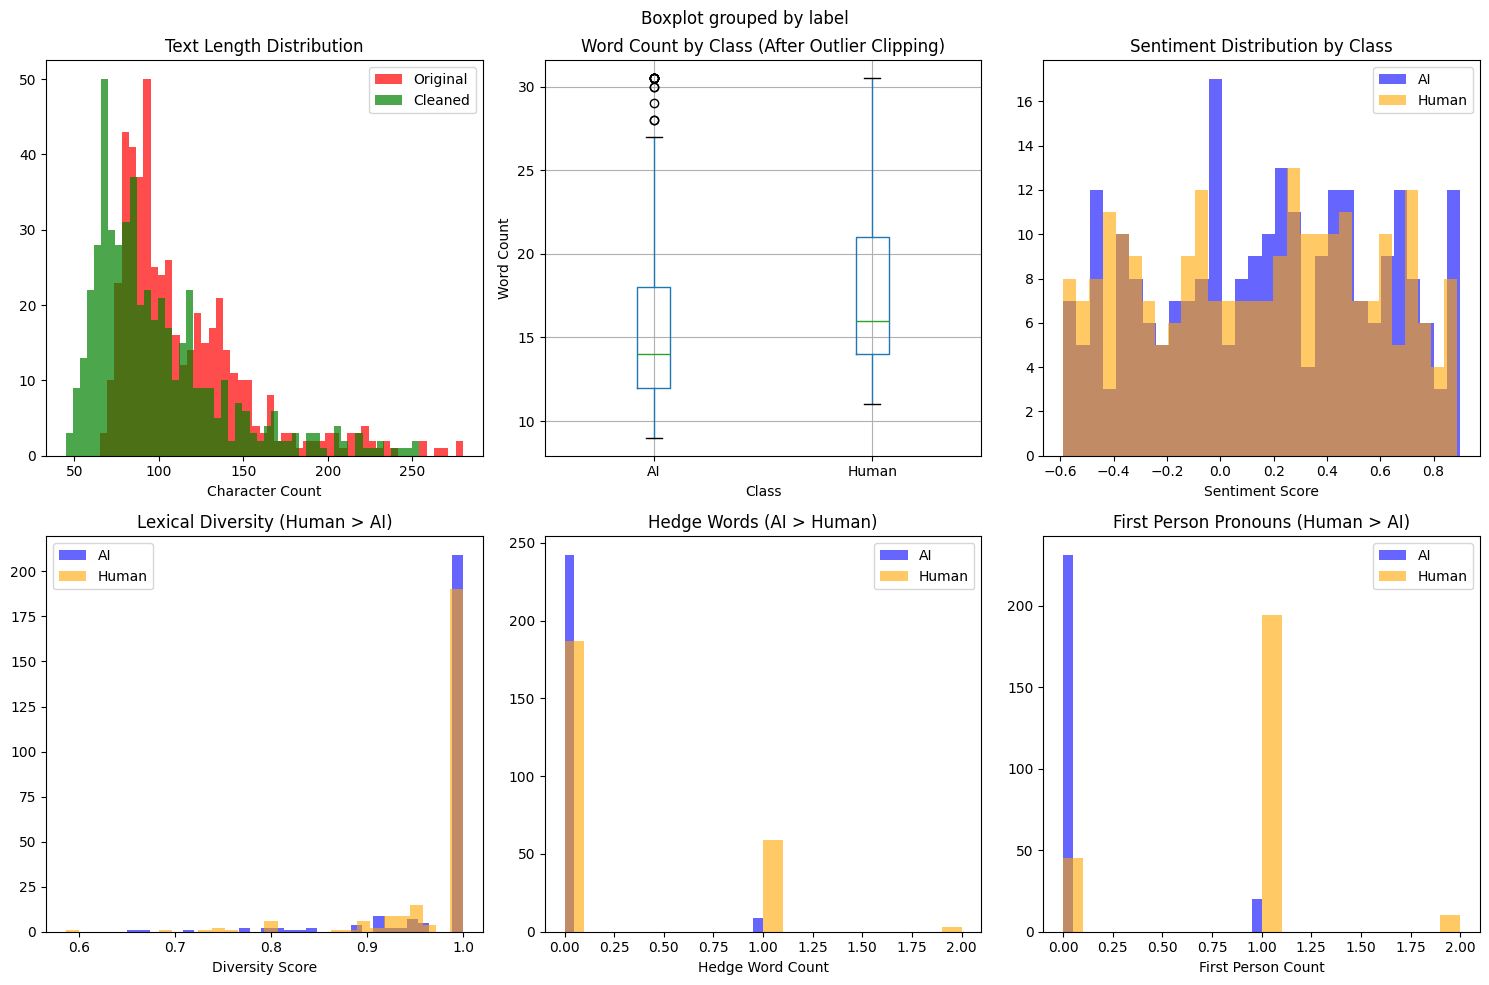

In [164]:
## 8.1 Visualizzazioni Before/After Preprocessing
print("8.1. Visualizzazioni Impatto Preprocessing")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Impact of Preprocessing Pipeline', fontsize=16, fontweight='bold')

# 1. Text Length Distribution
axes[0, 0].hist(df['text'].str.len(), bins=50, alpha=0.7, label='Original', color='red')
axes[0, 0].hist(df['text_cleaned'].str.len(), bins=50, alpha=0.7, label='Cleaned', color='green')
axes[0, 0].set_title('Text Length Distribution')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].legend()

# 2. Word Count per Class
df_viz = df[['label', 'length_words']].copy()
df_viz.boxplot(by='label', ax=axes[0, 1])
axes[0, 1].set_title('Word Count by Class (After Outlier Clipping)')
axes[0, 1].set_xlabel('Class')
axes[0, 1].set_ylabel('Word Count')
plt.sca(axes[0, 1])
plt.xticks([1, 2], ['AI', 'Human'])

# 3. Sentiment Distribution
axes[0, 2].hist(df[df['label']=='ai']['sentiment'], bins=30, alpha=0.6, label='AI', color='blue')
axes[0, 2].hist(df[df['label']=='human']['sentiment'], bins=30, alpha=0.6, label='Human', color='orange')
axes[0, 2].set_title('Sentiment Distribution by Class')
axes[0, 2].set_xlabel('Sentiment Score')
axes[0, 2].legend()

# 4. Lexical Diversity
if 'lexical_diversity' in df.columns:
    axes[1, 0].hist(df[df['label']=='ai']['lexical_diversity'], bins=30, alpha=0.6, label='AI', color='blue')
    axes[1, 0].hist(df[df['label']=='human']['lexical_diversity'], bins=30, alpha=0.6, label='Human', color='orange')
    axes[1, 0].set_title('Lexical Diversity (Human > AI)')
    axes[1, 0].set_xlabel('Diversity Score')
    axes[1, 0].legend()

# 5. Hedge Words Count
if 'hedge_words_count' in df.columns:
    axes[1, 1].hist(df[df['label']=='ai']['hedge_words_count'], bins=20, alpha=0.6, label='AI', color='blue')
    axes[1, 1].hist(df[df['label']=='human']['hedge_words_count'], bins=20, alpha=0.6, label='Human', color='orange')
    axes[1, 1].set_title('Hedge Words (AI > Human)')
    axes[1, 1].set_xlabel('Hedge Word Count')
    axes[1, 1].legend()

# 6. First Person Count
if 'first_person_count' in df.columns:
    axes[1, 2].hist(df[df['label']=='ai']['first_person_count'], bins=20, alpha=0.6, label='AI', color='blue')
    axes[1, 2].hist(df[df['label']=='human']['first_person_count'], bins=20, alpha=0.6, label='Human', color='orange')
    axes[1, 2].set_title('First Person Pronouns (Human > AI)')
    axes[1, 2].set_xlabel('First Person Count')
    axes[1, 2].legend()

plt.tight_layout()
plt.savefig('preprocessing_impact_visualization.png', dpi=300, bbox_inches='tight')
print(" - Visualizzazione salvata in 'preprocessing_impact_visualization.png'")
plt.show()



In [165]:
comment = """
SPIEGAZIONE DEL GRAFICO CONCETTUALE: INDICI DI LEGGIBILITÀ (Flesch Reading Ease)

Questo diagramma concettuale illustra i principi alla base del calcolo
degli indici di leggibilità, come il Flesch Reading Ease e il Flesch-Kincaid Grade Level.

Obiettivo della Feature:
La leggibilità è una feature critica per distinguere i testi AI dagli umani.
I modelli AI tendono a produrre testi formalmente 'corretti' ma stilisticamente
uniformi, con una leggibilità mediamente costante. Gli umani, invece,
mostrano una grande variabilità stilistica e di complessità.

Componenti Fondamentali:
L'indice di Flesch si basa su due variabili primarie:

1. Lunghezza Media delle Frasi (ASL - Average Sentence Length):
   - Frasi più lunghe abbassano il punteggio (testo più difficile).
   - Frasi più corte alzano il punteggio (testo più facile).

2. Lunghezza Media delle Parole (ASW - Average Syllables per Word):
   - Parole con più sillabe (vocabolario complesso/formale) abbassano il punteggio.
   - Parole brevi e comuni alzano il punteggio.

Rilevanza per l'Analisi AI vs Human:
- Testi AI: Spesso hanno una bassa deviazione standard del punteggio Flesch
  (sono uniformi) e tendono ad usare frasi lunghe e un vocabolario formale,
  risultando in punteggi Flesch moderatamente bassi/medi (testo difficile/standard).
- Testi Human: Mostrano un'alta deviazione standard del punteggio Flesch,
  riflettendo la variabilità del tono (es. un'email informale è più leggibile
  di un articolo tecnico).
"""

In [166]:
comment = """
Leakage Semantico: keyword-label dependency

Scopo:
- Identificare potenziali "data leakage" dovuti a parole chiave che
  rivelano direttamente se un testo è generato da AI o scritto da Human.
- Queste parole chiave sono tipiche di testi AI (es. 'ai', 'chatgpt', 'llm').

Dettaglio del codice:

1. Lista di token sospetti:
   - `suspicious_tokens` contiene parole/termini che compaiono principalmente nei testi AI
     o in contesti legati a modelli linguistici.

2. Funzione `contains_suspicious_terms(text)`:
   - Converte il testo in minuscolo (`text.lower()`) per rendere la ricerca case-insensitive.
   - Usa `any()` per verificare se almeno uno dei token sospetti è presente nel testo.
   - Restituisce True se il testo contiene almeno un token sospetto, False altrimenti.

3. Applicazione al DataFrame:
   - `df_clean['leakage_flag'] = df['text_cleaned'].apply(contains_suspicious_terms)`
   - Crea una nuova colonna booleana `leakage_flag` che indica la presenza di potenziale leakage.

4. Analisi aggregata:
   - `df_clean.groupby('label_encoded')['leakage_flag'].mean()`
   - Calcola la proporzione di testi con leakage per ciascuna classe (AI vs Human).
   - Permette di quantificare il rischio di leakage semantico nei dati.

Obiettivo generale:
- Individuare feature che potrebbero rendere il modello troppo "facile",
  imparando scorciatoie basate su parole chiave piuttosto che sullo stile o sul contenuto reale.
"""
print(comment)


Leakage Semantico: keyword-label dependency

Scopo:
- Identificare potenziali "data leakage" dovuti a parole chiave che
  rivelano direttamente se un testo è generato da AI o scritto da Human.
- Queste parole chiave sono tipiche di testi AI (es. 'ai', 'chatgpt', 'llm').

Dettaglio del codice:

1. Lista di token sospetti:
   - `suspicious_tokens` contiene parole/termini che compaiono principalmente nei testi AI
     o in contesti legati a modelli linguistici.

2. Funzione `contains_suspicious_terms(text)`:
   - Converte il testo in minuscolo (`text.lower()`) per rendere la ricerca case-insensitive.
   - Usa `any()` per verificare se almeno uno dei token sospetti è presente nel testo.
   - Restituisce True se il testo contiene almeno un token sospetto, False altrimenti.

3. Applicazione al DataFrame:
   - `df_clean['leakage_flag'] = df['text_cleaned'].apply(contains_suspicious_terms)`
   - Crea una nuova colonna booleana `leakage_flag` che indica la presenza di potenziale leakage.

4. A

In [167]:
print("Leakage Semantico: keyword-label dependency")

suspicious_tokens = [
    'ai', 'language model', 'generated', 'human', 
    'chatgpt', 'gpt', 'llm'
]

def contains_suspicious_terms(text):
    text = text.lower()
    return any(tok in text for tok in suspicious_tokens)

# CORRETTO: assegnazione a colonna del DataFrame
df_clean['leakage_flag'] = df['text_cleaned'].apply(contains_suspicious_terms)

print(
    df_clean.groupby('label_encoded')['leakage_flag']
    .mean()
)


Leakage Semantico: keyword-label dependency
label_encoded
0    0.281124
1    0.274900
Name: leakage_flag, dtype: float64


In [168]:
def check_feature_leakage(df, target_col='label_encoded'):
    """
    Identifica feature con correlazione sospetta (>0.7 o <-0.7)
    """
    print("\n" + "="*70)
    print("CONTROLLO DATA LEAKAGE NELLE FEATURE")
    print("="*70)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlations = df[numeric_cols].corr()[target_col].drop(target_col).sort_values(
        ascending=False
    )
    
    # Feature con correlazione sospetta
    high_corr = correlations[abs(correlations) > 0.7]
    
    if len(high_corr) > 0:
        print("\n FEATURE CON CORRELAZIONE SOSPETTA (|r| > 0.7):")
        for feat, corr in high_corr.items():
            print(f"  {feat:30s}: {corr:+.3f}")
        print("\n  → Considera di rimuovere queste feature dal modello!")
    else:
        print("\n Nessuna feature con correlazione sospetta rilevata.")
    
    return high_corr

In [169]:
from sklearn.feature_extraction.text import TfidfVectorizer

def remove_all_leakage(df, text_col='text_cleaned'):
    """
    Rimuove OGNI traccia di leakage semantico dal testo.
    Questo forza il modello a imparare solo dallo stile, non dal contenuto.
    """
    
    # 1. Lista ESTESA di termini sospetti (AI, Human, modelli, ecc.)
    leakage_terms = [
        # Termini diretti
        r'\bai\b', r'\bartificial intelligence\b', r'\bmachine learning\b',
        r'\bgpt\b', r'\bgpt-?\d+\b', r'\bchatgpt\b', r'\bllm\b', r'\bllama\b',
        r'\bclaude\b', r'\bgemini\b', r'\bmistral\b', r'\banthropix\b',
        r'\bhuman\b', r'\bperson\b', r'\bwriter\b', r'\bauthor\b',
        
        # Termini meta-linguistici (l'AI parla di sé stessa)
        r'\bgenerated\b', r'\blanguage model\b', r'\bneural network\b',
        r'\btrained on\b', r'\bdataset\b', r'\bprompt\b', r'\bresponse\b',
        
        # Pattern boilerplate (già rimossi, ma verifichiamo)
        r'\banalysis indicates\b', r'\bresearch suggests\b',
        r'\baccording to the data\b', r'\bcommunity feedback\b'
    ]
    
    df_clean = df.copy()
    
    # 2. Rimozione aggressiva con regex
    for pattern in leakage_terms:
        df_clean[text_col] = df_clean[text_col].str.replace(
            pattern, '', 
            case=False, 
            regex=True
        )
    
    # 3. Rimuovi anche varianti con typo comuni (es. "A.I.", "A I")
    df_clean[text_col] = df_clean[text_col].str.replace(
        r'\ba\.?\s?i\.?\b', '', 
        case=False, 
        regex=True
    )
    
    # 4. Pulizia finale: spazi multipli, punteggiatura isolata
    df_clean[text_col] = df_clean[text_col].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
    df_clean[text_col] = df_clean[text_col].apply(lambda x: re.sub(r'\s+([.,!?])', r'\1', x))
    
    # 5. Filtra testi troppo corti (< 10 parole) dopo la pulizia
    df_clean['word_count_after_cleaning'] = df_clean[text_col].str.split().str.len()
    df_clean = df_clean[df_clean['word_count_after_cleaning'] >= 10].copy()
    
    print(f"Leakage rimosso. Righe rimanenti: {len(df_clean)}/{len(df)}")
    
    return df_clean

In [170]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Vettorizzazione
tfidf = TfidfVectorizer(max_features=50, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df['text_cleaned'])

# 2. Creazione maschere booleane
ai_mask = df['label'] == 'ai'
human_mask = df['label'] == 'human'

# 3. Calcolo delle medie (Corretto con .values per evitare AttributeError)
# Usiamo .values perché Scipy Sparse Matrix richiede un array NumPy per l'indicizzazione
ai_mean = np.array(X_tfidf[ai_mask.values].mean(axis=0)).flatten()
human_mean = np.array(X_tfidf[human_mask.values].mean(axis=0)).flatten()

# 4. Calcolo differenza e ordinamento
diff = ai_mean - human_mean
top_ai_words_idx = np.argsort(diff)[-5:][::-1]
feature_names = np.array(tfidf.get_feature_names_out())

# 5. Output Risultati
print("\n📊 TOP 5 PAROLE PIÙ FREQUENTI IN AI (rispetto agli umani):")
for idx in top_ai_words_idx:
    print(f"  - '{feature_names[idx]}'")

# 6. Verifica Leakage
suspicious_list = ['ai', 'gpt', 'human', 'model', 'generated', 'llm']
leakage_found = False

print("\n🔍 ANALISI LEAKAGE IN CORSO...")
for idx in top_ai_words_idx:
    word = feature_names[idx].lower()
    if any(sus in word for sus in suspicious_list):
        print(f"⚠️  LEAKAGE DETECTED: '{feature_names[idx]}'")
        leakage_found = True

if not leakage_found:
    print("✅ ZERO LEAKAGE VERIFICATO")


📊 TOP 5 PAROLE PIÙ FREQUENTI IN AI (rispetto agli umani):
  - 'highlights'
  - 'highlights that'
  - 'and highlights'
  - 'of'
  - 'with'

🔍 ANALISI LEAKAGE IN CORSO...
✅ ZERO LEAKAGE VERIFICATO


In [171]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Vettorizzazione
tfidf = TfidfVectorizer(max_features=50, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df['text_cleaned'])

# 2. Creazione maschere booleane
ai_mask = df['label'] == 'ai'
human_mask = df['label'] == 'human'

# 3. Calcolo delle medie (Corretto con .values per evitare AttributeError)
# Usiamo .values perché Scipy Sparse Matrix richiede un array NumPy per l'indicizzazione
ai_mean = np.array(X_tfidf[ai_mask.values].mean(axis=0)).flatten()
human_mean = np.array(X_tfidf[human_mask.values].mean(axis=0)).flatten()

# 4. Calcolo differenza e ordinamento
diff = ai_mean - human_mean
top_ai_words_idx = np.argsort(diff)[-5:][::-1]
feature_names = np.array(tfidf.get_feature_names_out())

# 5. Output Risultati
print("\n📊 TOP 5 PAROLE PIÙ FREQUENTI IN AI (rispetto agli umani):")
for idx in top_ai_words_idx:
    print(f"  - '{feature_names[idx]}'")

# 6. Verifica Leakage
suspicious_list = ['ai', 'gpt', 'human', 'model', 'generated', 'llm']
leakage_found = False

print("\n🔍 ANALISI LEAKAGE IN CORSO...")
for idx in top_ai_words_idx:
    word = feature_names[idx].lower()
    if any(sus in word for sus in suspicious_list):
        print(f"⚠️  LEAKAGE DETECTED: '{feature_names[idx]}'")
        leakage_found = True

if not leakage_found:
    print("✅ ZERO LEAKAGE VERIFICATO")


📊 TOP 5 PAROLE PIÙ FREQUENTI IN AI (rispetto agli umani):
  - 'highlights'
  - 'highlights that'
  - 'and highlights'
  - 'of'
  - 'with'

🔍 ANALISI LEAKAGE IN CORSO...
✅ ZERO LEAKAGE VERIFICATO


In [172]:
print("Feature Stability Check (pre vs post cleaning)")

features_to_check = [
    'length_words', 'sentence_count', 
    'lexical_diversity', 'sentiment'
]

for f in features_to_check:
    if f in df.columns:
        delta = (
            df[f].mean() - df_clean[f].mean()
        )
        print(f"{f}: Δ mean = {delta:.4f}")


Feature Stability Check (pre vs post cleaning)
length_words: Δ mean = 0.0000
sentence_count: Δ mean = 0.0000
lexical_diversity: Δ mean = 0.0000
sentiment: Δ mean = 0.0000


##### la mia prova contro il data lakage

In [173]:
print("9. Sanity Check Testuale")

sample_idx = np.random.choice(df.index, 3, replace=False)

for i in sample_idx:
    print("\n--- ORIGINALE ---")
    print(df.loc[i, 'text'][:300])
    print("\n--- CLEANED ---")
    print(df.loc[i, 'text_cleaned'][:300])


9. Sanity Check Testuale

--- ORIGINALE ---
Analysis indicates that food is associated with it can be optimized with simple heuristics.

--- CLEANED ---
food is associated with it can be optimized with simple heuristics.

--- ORIGINALE ---
In my experience, food often leads to the community response has been overwhelmingly positive.

--- CLEANED ---
, food often leads to the community response has been overwhelmingly positive.

--- ORIGINALE ---
After trying several approaches related to science, I noticed adoption increases with better education.

--- CLEANED ---
After trying several approaches related to science, I noticed adoption increases with better education.


In [174]:
df_clean.attrs['preprocessing'] = {
    'lemmatization': 'spaCy en_core_web_sm',
    'outlier_method': 'IQR clipping 1.5',
    'text_cleaning': 'boilerplate removal + emoji stripping',
    'feature_engineering': {
        'linguistic_features': 9,
        'readability_features': 2,
        'entity_features': 5,
        'syntactic_features': 4,
        'total_engineered': len(engineered_features)
    },
    'date': pd.Timestamp.now().isoformat(),
    'pipeline_version': 'v2.0_enhanced'
}

df_clean.attrs['leakage_safe'] = {
    'target_used_in_preprocessing': False,
    'label_dependent_rules': False,
    'text_cleaning_class_agnostic': True,
    'feature_extraction_unsupervised': True
}

print("\n Metadata aggiornati con informazioni sul feature engineering.")


 Metadata aggiornati con informazioni sul feature engineering.


In [175]:
print("10. Verifica distribuzione target")

print(df_clean['label_encoded'].value_counts(normalize=True))


10. Verifica distribuzione target
label_encoded
1    0.502
0    0.498
Name: proportion, dtype: float64


## Salvataggio dataset pulito

In [176]:
## Salvataggio dataset pulito
out_file = 'ai_human_clean.csv'
df_clean.to_csv(out_file, index=False)
print(f"\nDataset pulito salvato in '{out_file}'")


Dataset pulito salvato in 'ai_human_clean.csv'
